# Множественная проверка гипотез

В этой тетрадке мы будем работать с данными про Баскетбол.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats as sts
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.sandbox.stats.multicomp import multipletests 

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

В файле `basketball.tsv` лежит [статистика о штрафных бросках в играх в Баскетбол, собранная с сайта ESPN.com](https://www.kaggle.com/sebastianmantey/nba-free-throws)

__Описание колонок:__

* `end_result` - результат игры
* `game` - какие команды играли, команда справа - хозяин площадки
* `game_id` - уникальный id игры
* `period` - период
* `player` - имя игрока
* `playoff` - тип игры
* `score` - счёт после броска 
* `season` - сезон игры
* `shot_made` - попал или не попал в кольцо при броске 
* `time` - время броска 
* `command` - предполагаемая команда игрока (колонка рассчитана по датасету)
* `is_home` - домашний матч или в гостях

In [2]:
df = pd.read_csv('data/basketball.tsv', sep='\t')
print(df.shape)
df.head()

(618019, 13)


,end_result,game,game_id,period,play,player,playoffs,score,season,shot_made,time,command,is_home
0,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,0 - 1,2006 - 2007,1,11:45,LAL,False
1,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 2 of 2,Andrew Bynum,regular,0 - 2,2006 - 2007,1,11:45,LAL,False
2,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,18 - 12,2006 - 2007,1,7:26,LAL,False
3,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum misses free throw 2 of 2,Andrew Bynum,regular,18 - 12,2006 - 2007,0,7:26,LAL,False
4,106 - 114,PHX - LAL,261031013.0,1.0,Shawn Marion makes free throw 1 of 1,Shawn Marion,regular,21 - 12,2006 - 2007,1,7:18,PHX,True


# 1. Доля попаданий в корзину

Немного посмотрим на наши данные. Ответьте на следующие вопросы и запишите ответы в соотвествующие переменные. 

Сколько уникальных игр было сыграно в течение всего периода, который есть в таблице (`ans1`)? Сколько в данных встречается уникальных игроков (`ans2`)?

In [3]:
# your code here
ans1 = df.game_id.nunique()
ans2 = df.player.nunique()

print(f'Сыграно уникальных игр в течение всего периода: {ans1}')
print(f'Количество уникальных игроков: {ans2}')

Сыграно уникальных игр в течение всего периода: 12874
Количество уникальных игроков: 1098


Подсчитайте по каждому игроку статистику, связанную с тем, как часто он попадет в корзину при бросках:

- Долю попаданий в корзину среди его бросков, $\hat{p}$
- Число бросков, которое было сделано игроком, $n$

Среди игроков, которые сделали более ста бросков, найдите самого успешного. Запишите его в переменную `ans3`.

In [4]:
# your code here

stats_players = (
    df
      .groupby('player', as_index=False)
      .agg({'shot_made': ['count', 'mean']})
)

stats_players.columns = ['name', 'total', 'perc']
best = stats_players[stats_players.total > 100]

ans3 = best.loc[best.perc.idxmax][0]

print(f'Самый успешный игрок с количеством бросков > 100: {ans3}')

Самый успешный игрок с количеством бросков > 100: Steve Nash


Для поиска `ans4` и `ans5` используйте данные по игрокам, сделавшим более ста бросков.  

Найдите медиану распределения доли попаданий, запишите её в переменную `ans4`. Найдите значение коэффициента асимметрии, запишите его в переменную `ans5`. Какое значение он принимает? Правда ли, что распределение этой переменной оказывается скошенным?

Постройте гистограмму для доли попаданий игроков, нарисуйте на ней пунктирной линией медиану. Проинтерпретируйте то, что вы видите на рисунке. 

In [5]:
# your code here

ans4 = best.perc.median()
ans5 = sts.skew(best.perc)

print(f'Медиана распределения доли попаданий = {ans4:.3}')
print(f'Распределение скошено влево, коэф. асимметрии = {ans5:.4}')

Медиана распределения доли попаданий = 0.757
Распределение скошено влево, коэф. асимметрии = -1.037


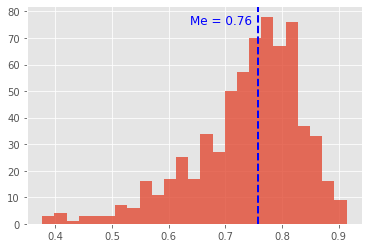

In [6]:
plt.hist(best.perc, bins=25, alpha=0.8)
plt.axvline(ans4, color="blue", linestyle='dashed', lw=2)
plt.text(ans4 - 0.12, plt.ylim()[1] * 0.92, f'Me = {ans4:.2}', color='blue', fontsize=12);

Видно, что распределение скошено - у него более тяжелый левый хвост.

# 2. Игры дома и в гостях

Проанализируем, как часто игроки попадают в корзину дома и как часто в гостях. Подсчитайте доли попаданий в корзину в гостях и дома для всех ироков из выборки. Если для какого-то игрока оказывается, что он всегда играл только дома/только в гостях, удалите его из выборки.

Проверьте гипотезу о равенстве этих долей для каждого игрока против двусторонней альтернативы. Число гипотез, которые отклоняются на уровне значимости $5\%$,  запишите в переменную `ans6`. 

In [7]:
# your code here

# Сгруппируем данные и сделаем необходимы расчеты
score = (
    df
      .groupby(['player', 'is_home'], as_index=False)
      .agg({'shot_made': ['count', 'sum', 'mean']})
      .pivot(index='player', columns='is_home', values=[('shot_made', 'count'), ('shot_made', 'sum'), ('shot_made',  'mean')])
      .dropna()
)

score.columns = ['away_total', 'home_total', 'away_result', 'home_result', 'away_mean', 'home_mean']

# Посмотрим на итоговый датасет
print(f'Размерность данных: {score.shape}')
score.head()

Размерность данных: (1028, 6)


,away_total,home_total,away_result,home_result,away_mean,home_mean
player,,,,,,
A.J. Price,150.0,132.0,115.0,96.0,0.766667,0.727273
Aaron Brooks,572.0,537.0,474.0,454.0,0.828671,0.845438
Aaron Gordon,134.0,120.0,92.0,81.0,0.686567,0.675000
Aaron Gray,147.0,192.0,91.0,98.0,0.619048,0.510417
Aaron Williams,26.0,14.0,20.0,12.0,0.769231,0.857143


In [8]:
# Объявим функцию для проверки гипотезы о равенстве долей
def get_proportions_ztest_pvalue(df):
    n_away = df.away_total
    m_away = df.away_result

    n_home = df.home_total
    m_home = df.home_result
    
    _, p =  proportions_ztest((m_away, m_home), (n_away, n_home), value=0, alternative='two-sided')
    return p

# Проверим гипотезы о равенстве долей попадания в корзину для каждого игрока
score['pvalue'] = score.apply(get_proportions_ztest_pvalue, axis=1)
score.head()

,away_total,home_total,away_result,home_result,away_mean,home_mean,pvalue
player,,,,,,,
A.J. Price,150.0,132.0,115.0,96.0,0.766667,0.727273,0.446938
Aaron Brooks,572.0,537.0,474.0,454.0,0.828671,0.845438,0.450220
Aaron Gordon,134.0,120.0,92.0,81.0,0.686567,0.675000,0.843453
Aaron Gray,147.0,192.0,91.0,98.0,0.619048,0.510417,0.045971
Aaron Williams,26.0,14.0,20.0,12.0,0.769231,0.857143,0.507335


In [9]:
# Число гипотез, которые отклоняются на уровне значимости 5%
ans6 = (score.pvalue < 0.05).sum()
print(f'Число отклоняемых нулевых гипотез на уровне значимости 5% => {ans6}')

Число отклоняемых нулевых гипотез на уровне значимости 5% => 70


Введите коррекцию с помощью метода Холма. Запишите число гипотез, которые были отклонены на уровне значимости $5\%$, в переменную `ans7`.

In [10]:
# your code here
rejected, p_corrected, _, _ = multipletests(score['pvalue'].values, alpha = 0.05, method = 'holm') 
ans7 = (p_corrected < 0.05).sum()
print(f'Число отклоняемых нулевых гипотез на уровне значимости 5% => {ans7}')

Число отклоняемых нулевых гипотез на уровне значимости 5% => 0


Введите коррекцию с помощью метода Бенжамини-Хохберга. Запишите число гипотез, которые были отклонены на уровне значимости $5\%$, в переменную `ans8`.

In [11]:
# your code here
rejected, p_corrected, _, _ = multipletests(score['pvalue'].values, alpha = 0.05, method = 'fdr_bh') 
ans8 = (p_corrected < 0.05).sum()
print(f'Число отклоняемых нулевых гипотез на уровне значимости 5% => {ans8}')

Число отклоняемых нулевых гипотез на уровне значимости 5% => 0


Объясните разницу, которую вы получили в количестве отклоненных гипотез.

**Oбъяснение**:
- C ростом числа проверяемых гипотез, вероятность получить ошибку растёт экспоненциально: $ 1 − (1 − \alpha)^n $
- Нужно скорректировать исходный уровень значимости $ \alpha $
- Метод Холма – улучшение поправки Бонферрони, обладает более высокой мощностью
- Метод Бенджамини-Хохберга обычно оказывается более мощным, чем методы контролирующие FWER (Family-Wise Error Rate)
- Корректировка уровня значимости помогает держать под контролем ложно-положительные результаты

<br>